In [8]:
import torch
import numpy as np
import skimage.io
import skimage
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import random
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [9]:
random.seed(38)
torch.manual_seed(38)
# use for random generation
fixed_noise = Variable(torch.randn(32, 100, 1, 1)).cuda()

In [10]:
# load data
train_X = np.load("all_img_flip.npy")

In [11]:
train_X = torch.from_numpy(train_X).type(torch.FloatTensor)

In [12]:
class Generator(nn.Module):
    def __init__(self, figsize=64):
        super(Generator, self).__init__()
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 100, figsize * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(figsize * 8),
            nn.ReLU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(figsize * 8, figsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 4),
            nn.ReLU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(figsize * 4, figsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 2),
            nn.ReLU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(figsize * 2, figsize, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(figsize, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, X):
        output = self.decoder(X)/2.0+0.5
        return output
    
class Discriminator(nn.Module):
    def __init__(self, figsize=64):
        super(Discriminator, self).__init__()
        self.decoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, figsize, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(figsize, figsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(figsize * 2, figsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(figsize * 4, figsize * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(figsize * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, X):
        output = self.decoder(X)

        return output.view(-1, 1).squeeze(1)

In [13]:
# training
latent_size = 100

G = Generator().cuda()
D = Discriminator().cuda()
criterion = nn.BCELoss()
# setup optimizer
optimizerG = optim.Adam(G.parameters(), lr=0.0002)
optimizerD = optim.Adam(D.parameters(), lr=0.0002)

BATCH_SIZE = 64

D_loss_list = []
G_loss_list = []
D_fake_acc_list = []
D_real_acc_list = []
for epoch in range(100):
    print("Epoch:", epoch+1)
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    D_fake_acc = 0.0
    D_real_acc = 0.0
    total_length = len(train_X)
    # shuffle
    perm_index = torch.randperm(total_length)
    train_X_sfl = train_X[perm_index]

    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
            
        # zero the parameter gradients
        D.zero_grad()
        input_X = train_X_sfl[index:index+BATCH_SIZE]
        
        #### train with real image -> ground truth = real label
        real_image = Variable(input_X.cuda()) # use GPU 
        real_label = Variable(torch.ones((BATCH_SIZE))).cuda()
        output = D(real_image)
        D_real_loss = criterion(output, real_label)
        D_real_acc += np.mean(((output > 0.5).cpu().data.numpy() == real_label.cpu().data.numpy()))
        
        #### train with fake image -> ground truth = fake label
        noise = Variable(torch.randn(BATCH_SIZE, 100, 1, 1)).cuda()
        fake_image = G(noise)
        fake_label = Variable(torch.zeros((BATCH_SIZE))).cuda()
        output = D(fake_image.detach())
        D_fake_loss = criterion(output, fake_label)
        D_fake_acc += np.mean(((output > 0.5).cpu().data.numpy() == fake_label.cpu().data.numpy()))
        
        # update D
        D_train_loss = D_real_loss + D_fake_loss
        epoch_D_loss+=(D_train_loss.data[0])
        D_train_loss.backward()
        optimizerD.step()
        
        #### train Generator
        for _ in range(2):
            G.zero_grad()
            # generate fake image
            noise = Variable(torch.randn(BATCH_SIZE, 100, 1, 1)).cuda()
            fake_image = G(noise)
            fake_label_for_G = Variable(torch.ones((BATCH_SIZE))).cuda()
            output = D(fake_image)
            G_loss = criterion(output, fake_label_for_G)
            epoch_G_loss += (G_loss.data[0])
            G_loss.backward()
            optimizerG.step()
        
    print("training D Loss:",epoch_D_loss/(total_length))
    print("training G Loss:", epoch_G_loss/(total_length))
    D_loss_list.append(epoch_D_loss/(total_length))
    G_loss_list.append(epoch_G_loss/(total_length))
    
    print("D_real_acc:", D_real_acc/(total_length/BATCH_SIZE))
    print("D_fake_acc:", D_fake_acc/(total_length/BATCH_SIZE))
    
    D_real_acc_list.append(D_real_acc/(total_length/BATCH_SIZE))
    D_fake_acc_list.append(D_fake_acc/(total_length/BATCH_SIZE))
    # evaluation
    G.eval()
    fixed_img_output = G(fixed_noise)
    G.train()
    torchvision.utils.save_image(fixed_img_output.cpu().data, './GAN_output/fig2_3_'+str(epoch+1)+'.jpg',nrow=8)
    
torch.save(G.state_dict(), "./models/G_model.pkt")

Epoch: 1
training D Loss: 0.025483505014638776
training G Loss: 0.03542418940865656
D_real_acc: 0.523040285305366
D_fake_acc: 0.49475610614485815
Epoch: 2
training D Loss: 0.025761874447999763
training G Loss: 0.02369044360947859
D_real_acc: 0.44235236151193075
D_fake_acc: 0.39555618122521763
Epoch: 3
training D Loss: 0.02419441534588974
training G Loss: 0.02419026600303723
D_real_acc: 0.4559372140494123
D_fake_acc: 0.4365336336547711
Epoch: 4
training D Loss: 0.02254955225513205
training G Loss: 0.02472269920835591
D_real_acc: 0.49629290725229347
D_fake_acc: 0.5034372727059431
Epoch: 5
training D Loss: 0.01824183795637053
training G Loss: 0.0376121065238934
D_real_acc: 0.6664672344618849
D_fake_acc: 0.7612327256516741
Epoch: 6
training D Loss: 0.014980198954045667
training G Loss: 0.051112397932882664
D_real_acc: 0.750029328265409
D_fake_acc: 0.834952253583914
Epoch: 7
training D Loss: 0.014082417289220208
training G Loss: 0.05907116565511691
D_real_acc: 0.7688698059641961
D_fake_acc:

training D Loss: 0.0051104202839458695
training G Loss: 0.10244349246696803
D_real_acc: 0.9472208535698364
D_fake_acc: 0.9462588864644189
Epoch: 58
training D Loss: 0.00461017442427731
training G Loss: 0.10426826424020394
D_real_acc: 0.9570751507472842
D_fake_acc: 0.9551981417611037
Epoch: 59
training D Loss: 0.004938264634189343
training G Loss: 0.10542685445863524
D_real_acc: 0.948781117289599
D_fake_acc: 0.9467164074048005
Epoch: 60
training D Loss: 0.004755709709128107
training G Loss: 0.10667070509169568
D_real_acc: 0.952382628281833
D_fake_acc: 0.9522653152201966
Epoch: 61
training D Loss: 0.004425105330764832
training G Loss: 0.10950513807897853
D_real_acc: 0.957427089932193
D_fake_acc: 0.9562891532343211
Epoch: 62
training D Loss: 0.0044459401833540765
training G Loss: 0.1116625488654689
D_real_acc: 0.9565355106637573
D_fake_acc: 0.9546115764529223
Epoch: 63
training D Loss: 0.0041710376935813675
training G Loss: 0.11263286820301795
D_real_acc: 0.9610168696182633
D_fake_acc: 0.

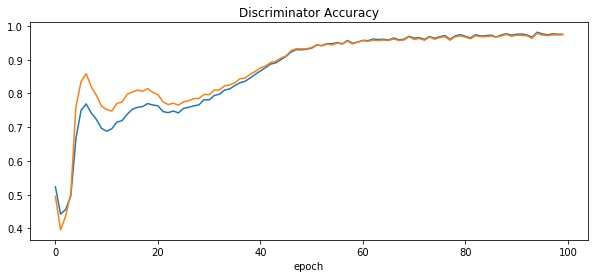

In [14]:
# plot loss
plt.figure(figsize=(10,4))

plt.plot(D_real_acc_list)
plt.plot(D_fake_acc_list)
plt.title("Discriminator Accuracy")
plt.xlabel("epoch")
plt.savefig("./GAN_output/fig2_2.jpg")
plt.show()

### Reference
https://github.com/pytorch/examples/tree/master/dcgan